In [2]:
import pandas as pd

In [63]:
# is there anyway to scrape all reviews from pages that link to multiple reviews
# example: https://pitchfork.com/reviews/albums/bruce-springsteen-the-album-collection-vol-2-1987-1996/
reviews_csv = pd.read_csv('reviews_stripped.csv')

In [64]:
reviews_csv.head()

,album,artist,bnm,bnr,date,reviewer,score,url
0,4275,Jacquees,0,0,21 hrs ago,Jay Balfour,6.9,https://pitchfork.com/reviews/albums/jacquees-...
1,Call the Comet,Johnny Marr,0,0,June 21 2018,Stephen Thomas Erlewine,6.0,https://pitchfork.com/reviews/albums/johnny-ma...
2,Sorpresa Familia,Mourn,0,0,June 21 2018,Larry Fitzmaurice,7.7,https://pitchfork.com/reviews/albums/mourn-sor...
3,Heaven and Earth,Kamasi Washington,1,0,21 hrs ago,Nate Chinen,8.8,https://pitchfork.com/reviews/albums/kamasi-wa...
4,Lower East Suite Part Three,Onyx Collective,0,0,21 hrs ago,Jay Balfour,7.6,https://pitchfork.com/reviews/albums/onyx-coll...


In [65]:
reviews_csv.shape

(20245, 8)

In [67]:
reviews_csv.isnull().sum()

album        13
artist      732
bnm           0
bnr           0
date          0
reviewer      0
score         0
url           0
dtype: int64

In [68]:
# 'Various Artists' albums were scraped as nans, so replaced here
reviews_csv['artist'] = reviews_csv['artist'].fillna('Various Artists')

In [69]:
# 13 album titles either weren't there or didn't scrape properly
# not entirely sure what to do about that...but not crucial to our goal
reviews_csv['album'] = reviews_csv['album'].fillna('N/A')

In [ ]:
# clean up poor scraping of some artists names that led to repeats
# I think this actually arises in the case of those multi album reviews
# set_func = lambda x: ', '.join(set(x)) # function used to isolate artist name
# next line changes elements to list of strings and maps our function
# reviews_csv['artist'] = reviews_csv['artist'].str.split(',').map(set_func)
# oof this messes up artists that have a commma in their name

In [70]:
reviews_csv['date'][:20]

0       21 hrs ago
1     June 21 2018
2     June 21 2018
3       21 hrs ago
4       21 hrs ago
5     June 21 2018
6     June 21 2018
7       21 hrs ago
8     June 20 2018
9     June 20 2018
10    June 20 2018
11      21 hrs ago
12    June 19 2018
13    June 17 2018
14    June 18 2018
15    June 18 2018
16    June 19 2018
17    June 19 2018
18    June 18 2018
19    June 18 2018
Name: date, dtype: object

In [71]:
# fix dates that were scraped as '21 hours ago'
for i in [0, 3, 4, 7, 11]:
    reviews_csv.loc[i, 'date'] = 'June 22 2018'

In [72]:
# function used to changed date feature to datetime object
reviews_csv['date'] = pd.to_datetime(reviews_csv['date'].str.replace(' ', ''), format='%B%d%Y')

In [73]:
# split duplicate reviews into lists
# try splitting white space from artists and albums during scraping!!!
reviews_csv['score'] = reviews_csv['score'].str.split(',')
reviews_csv['album'] = reviews_csv['album'].str.split(r'(?<=\S);(?=\S)')
reviews_csv['artist'] = reviews_csv['artist'].str.split(r'(?<=\S);(?=\S)')

In [74]:
remove_idx = []
delete_count = 0
for idx, row in reviews_csv.iterrows():
    if len(row['score']) > 1:
        if row['artist'][0] == 'Various Artists':
            for i in range(len(row['album'])):
                reviews_csv = reviews_csv.append({'album': [row['album'][i]], 'artist': [row['artist'][0]], 
                                                  'bnm': row['bnm'],'bnr': row['bnr'], 'date': row['date'], 
                                                  'reviewer': row['reviewer'],'score': [row['score'][i]], 
                                                  'url': row['url']}, ignore_index=True)
        elif len(row['artist']) == len(row['album']) == len(row['score']):
            for i in range(len(row['album'])):
                reviews_csv = reviews_csv.append({'album': [row['album'][i]], 'artist': [row['artist'][i]], 
                                                  'bnm': row['bnm'],'bnr': row['bnr'], 'date': row['date'], 
                                                  'reviewer': row['reviewer'],'score': [row['score'][i]], 
                                                  'url': row['url']}, ignore_index=True)
        else:
            delete_count += 1
            
        remove_idx.append(idx)

In [75]:
len(remove_idx)

534

In [76]:
reviews_csv.drop(remove_idx, inplace=True)

In [77]:
reviews_csv.tail()['album'].apply(lambda x: x[0])

21624        Love You
21625       Guarapero
21626    Lost Blues 2
21627    360 Business
21628      360 Bypass
Name: album, dtype: object

In [78]:
for idx, row in reviews_csv.iterrows():
    try:
        if len(row['album']) > 1:
            reviews_csv.drop(idx, inplace=True)
    except:
        print(idx, row['album'])

In [79]:
for cat in ['album', 'artist', 'score']:
    reviews_csv[cat] = reviews_csv[cat].apply(lambda x: x[0])

In [80]:
reviews_csv.reset_index(drop=True, inplace=True)

In [81]:
reviews_csv['score'] = reviews_csv['score'].astype(float)

In [82]:
# sort by date
reviews_csv = reviews_csv.sort_values('date', ascending=False).reset_index(drop=True)

In [83]:
reviews_csv['day_of_week'] = reviews_csv['date'].dt.dayofweek

In [84]:
reviews_csv.head()

,album,artist,bnm,bnr,date,reviewer,score,url,day_of_week
0,4275,Jacquees,0,0,2018-06-22,Jay Balfour,6.9,https://pitchfork.com/reviews/albums/jacquees-...,4
1,Moodie EP,Yuno,0,0,2018-06-22,Margaret Farrell,7.4,https://pitchfork.com/reviews/albums/yuno-mood...,4
2,Heaven and Earth,Kamasi Washington,1,0,2018-06-22,Nate Chinen,8.8,https://pitchfork.com/reviews/albums/kamasi-wa...,4
3,Lower East Suite Part Three,Onyx Collective,0,0,2018-06-22,Jay Balfour,7.6,https://pitchfork.com/reviews/albums/onyx-coll...,4
4,June,Brendon Anderegg,0,0,2018-06-22,Philip Sherburne,7.4,https://pitchfork.com/reviews/albums/brendon-a...,4


In [85]:
reviews_csv.shape

(21092, 9)

In [86]:
sunday_drops = [x for x in reviews_csv[reviews_csv['day_of_week'] == 6].index.values if x < 2681]
reviews_csv.drop(sunday_drops, inplace=True)

In [87]:
reviews_csv.shape

(20988, 9)

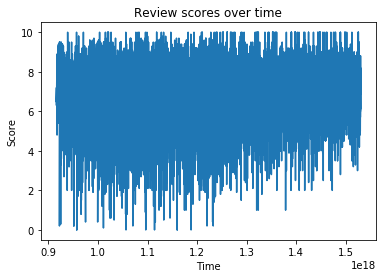

In [91]:
import matplotlib.pyplot as plt
# might have to remove their 'Sunday classics' reviews to get the fair picture
plt.plot(reviews_csv['date'], reviews_csv['score'])
plt.title('Review scores over time')
plt.xlabel('Time')
plt.ylabel('Score')
plt.savefig('all_reviews')
plt.show()

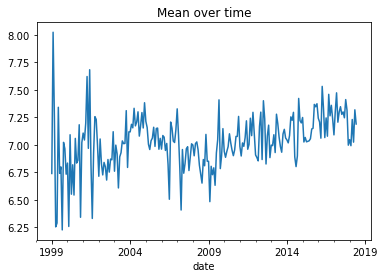

In [96]:
reviews_csv.set_index(reviews_csv['date']).resample('M').mean()['score'].plot()
plt.title('Mean over time')
plt.savefig('monthly_mean_alltime')
plt.show()

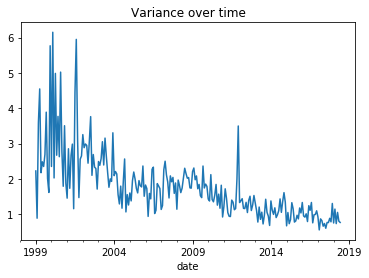

In [97]:
reviews_csv.set_index(reviews_csv['date']).resample('M').var()['score'].plot()
plt.title('Variance over time')
plt.savefig('monthly_var_alltime')
plt.show()

In [ ]:
# reviews_csv.set_index(reviews_csv['date']).truncate(after='2009-01-06')

In [72]:
reviews_csv.tail()

,album,artist,bnm,bnr,date,reviewer,score,url
21087,1999,Cassius,0,0,1999-01-26,James P. Wisdom,4.8,https://pitchfork.com/reviews/albums/1341-1999/
21088,Let Us Replay!,Coldcut,0,0,1999-01-26,James P. Wisdom,8.9,https://pitchfork.com/reviews/albums/1535-let-...
21089,Out of Tune,Mojave 3,0,0,1999-01-12,Jason Josephes,6.3,https://pitchfork.com/reviews/albums/5376-out-...
21090,"Singles Breaking Up, Vol. 1",Don Caballero,0,0,1999-01-12,James P. Wisdom,7.2,https://pitchfork.com/reviews/albums/2413-sing...
21091,Left for Dead in Malaysia,Neil Hamburger,0,0,1999-01-05,Jason Josephes,6.5,https://pitchfork.com/reviews/albums/3723-left...


In [92]:
reviews_since2010 = reviews_csv.iloc[:10629]

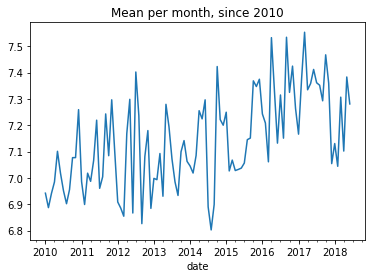

In [95]:
# an increase of 0.5 is notable when considering 1100-1200 reviews per year
reviews_since2010.set_index(reviews_since2010['date']).resample('M').mean()['score'].plot()
# plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.title('Mean per month, since 2010')
plt.show()

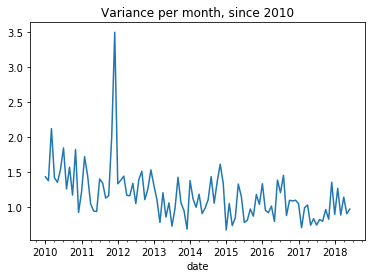

In [96]:
reviews_since2010.set_index(reviews_since2010['date']).resample('M').var()['score'].plot()
plt.title('Variance per month, since 2010')
plt.show()

In [97]:
# what reviews happened towards the end of 2011???
reviews_csv.loc[(reviews_csv['date'].dt.month==12) & (reviews_csv['date'].dt.year==2011) & (reviews_csv['score'] < 5)]
# I guess Pitchfork didn't like the two rap albums that defined my 9th grade year

,album,artist,bnm,bnr,date,reviewer,score,url
8211,Blue Slide Park,Mac Miller,0,0,2011-12-08,Jordan Sargent,1.0,https://pitchfork.com/reviews/albums/16113-blu...
8232,Camp,Childish Gambino,0,0,2011-12-02,Ian Cohen,1.6,https://pitchfork.com/reviews/albums/16074-camp/
8237,Ersatz G.B.,The Fall,0,0,2011-12-01,Douglas Wolk,2.2,https://pitchfork.com/reviews/albums/16081-the...


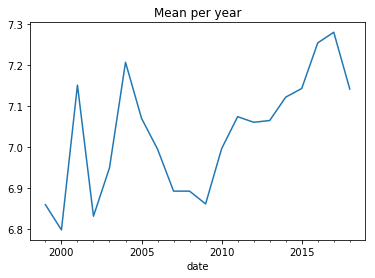

In [98]:
reviews_csv.set_index(reviews_csv['date']).resample('Y').mean()['score'].plot()
plt.title('Mean per year')
plt.savefig('annual_mean_alltime')
plt.show()

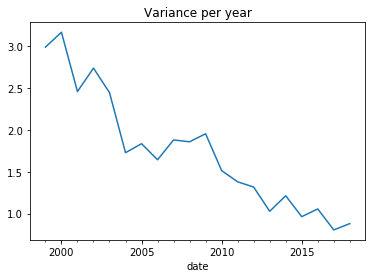

In [99]:
# definitely the most exciting and telling graph
# might be affected by number of reviews per year?
reviews_csv.set_index(reviews_csv['date']).resample('Y').var()['score'].plot()
plt.title('Variance per year')
plt.savefig('annual_var_alltime')
plt.show()

In [99]:
# reviews per year has been pretty constant since 2003
reviews_csv.set_index(reviews_csv['date']).resample('Y').count()['score']

date
1999-12-31     222
2000-12-31     351
2001-12-31     469
2002-12-31     928
2003-12-31    1082
2004-12-31    1178
2005-12-31    1257
2006-12-31    1248
2007-12-31    1244
2008-12-31    1253
2009-12-31    1231
2010-12-31    1216
2011-12-31    1214
2012-12-31    1248
2013-12-31    1229
2014-12-31    1226
2015-12-31    1203
2016-12-31    1354
2017-12-31    1298
2018-12-31     641
Freq: A-DEC, Name: score, dtype: int64

In [100]:
rev_count = reviews_csv.set_index(reviews_csv['date']).resample('Y').count()['score']

In [101]:
import numpy as np
np.mean(list(rev_count[6:19])) / 365
# average 3.42 reviews per day since 

3.4016859852476289

In [102]:
# last two years (2016, 2017) had the highest yearly means ever, with 2018 currently on pace to be third (re-check?)
reviews_csv.set_index(reviews_csv['date']).resample('Y').mean()['score']

date
1999-12-31    6.859459
2000-12-31    6.797721
2001-12-31    7.151599
2002-12-31    6.831250
2003-12-31    6.949445
2004-12-31    7.207301
2005-12-31    7.070406
2006-12-31    6.995032
2007-12-31    6.892524
2008-12-31    6.892418
2009-12-31    6.861251
2010-12-31    6.996217
2011-12-31    7.074465
2012-12-31    7.060737
2013-12-31    7.065012
2014-12-31    7.122104
2015-12-31    7.143308
2016-12-31    7.254710
2017-12-31    7.280723
2018-12-31    7.141977
Freq: A-DEC, Name: score, dtype: float64

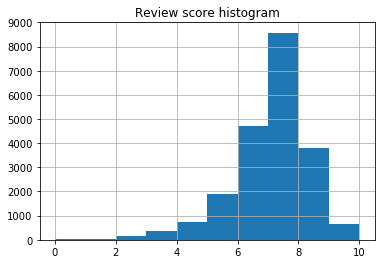

In [104]:
# now want to see a distribution of scores
reviews_csv.hist(column='score')
plt.title('Review score histogram')
plt.savefig('score_hist')
plt.show()

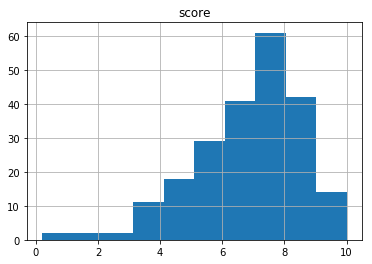

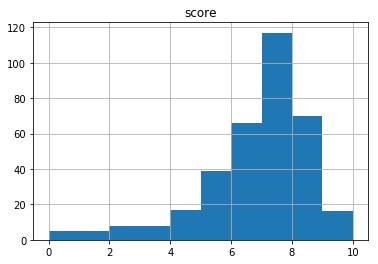

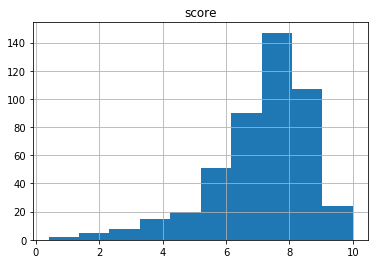

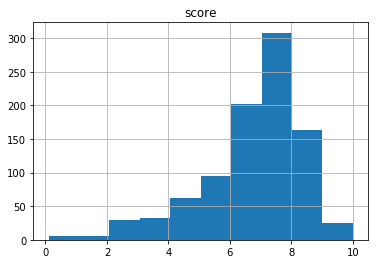

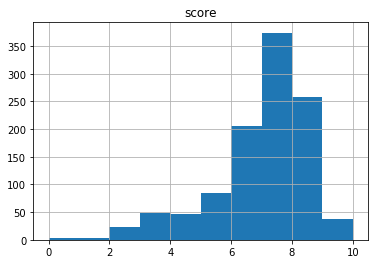

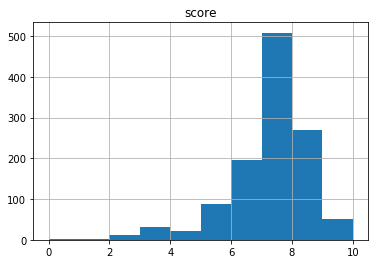

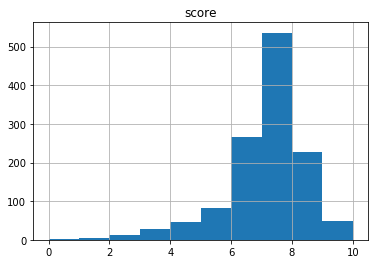

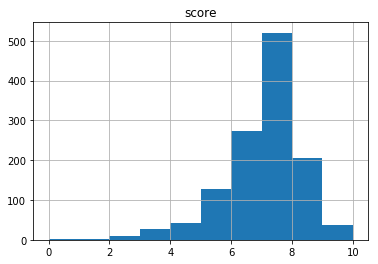

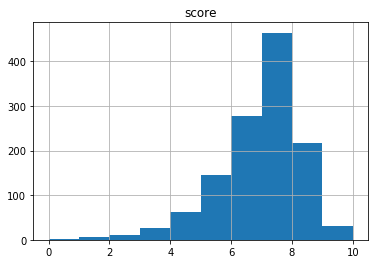

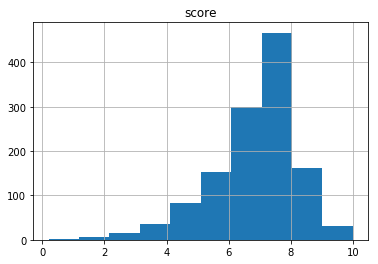

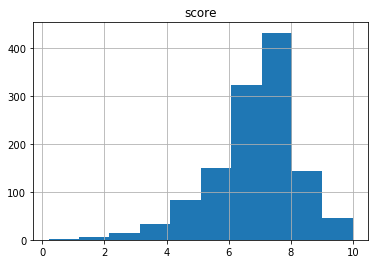

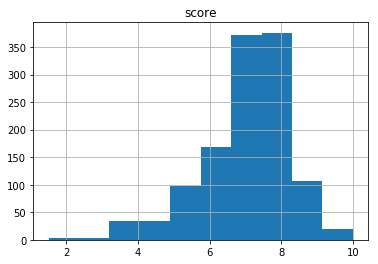

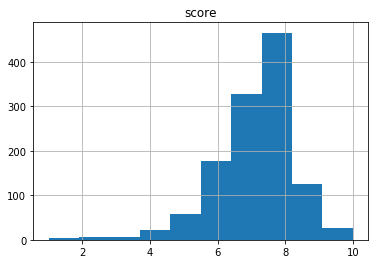

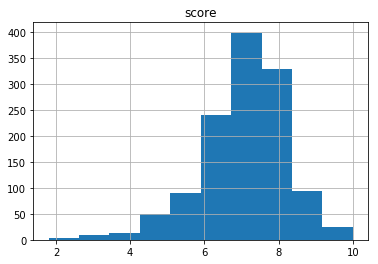

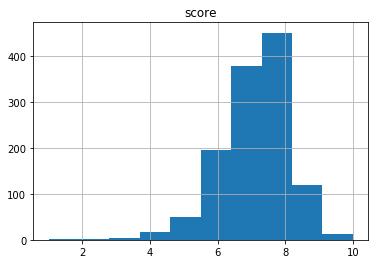

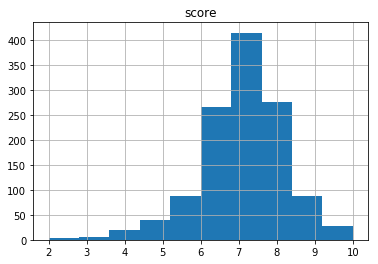

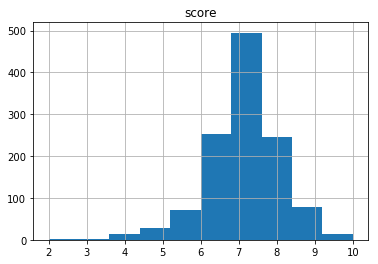

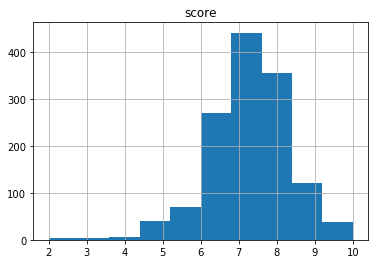

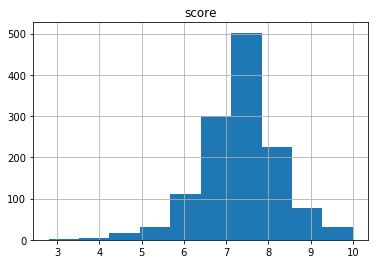

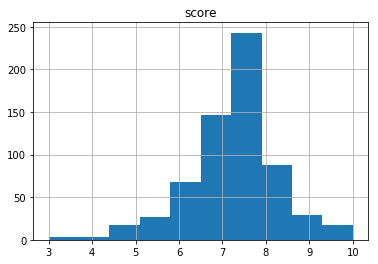

In [104]:
# histograms each year are pretty consistent
for idx, df, in reviews_csv.set_index(reviews_csv['date']).groupby(pd.Grouper(freq='Y')):
    df.hist(column='score')
plt.show()

In [106]:
# most common reviewers (200 or more)
common_reviewers = reviews_csv.groupby('reviewer').filter(lambda x: len(x) > 200)
mean_reviewer_scores = common_reviewers.groupby('reviewer').mean()['score']
reviewer_counts = common_reviewers.groupby('reviewer').count()['artist']
reviewers_df = pd.concat([mean_reviewer_scores, reviewer_counts], axis=1).sort_values(by='score', ascending=False)
reviewers_df.columns = ['avg_score', 'num_reviews']
reviewers_df

,avg_score,num_reviews
reviewer,,
Mark Richardson,7.668609,532
Dominique Leone,7.540924,303
Philip Sherburne,7.526198,313
Brandon Stosuy,7.521711,304
Marc Masters,7.511507,365
Andy Beta,7.509444,360
Joe Tangari,7.400350,858
Amanda Petrusich,7.386957,207
Chris Dahlen,7.359091,220


In [115]:
# most common artists reviewed
# reviews_csv['artist'].value_counts().drop('Various Artists')
common_artists = reviews_csv.groupby('artist').filter(lambda x: len(x) > 3)[reviews_csv['artist'] != 'Various Artists']
artist_means = common_artists.groupby('artist').mean()['score']

/Users/henryharris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [116]:
# can link to full list of results in article and only mention notables like alt-J
artist_means.sort_values(ascending=False)

artist
My Bloody Valentine                     9.650000
The Velvet Underground                  9.525000
Fleetwood Mac                           9.050000
Pavement                                9.000000
This Heat                               8.980000
The Beatles                             8.940909
Kendrick Lamar                          8.920000
GAS                                     8.900000
Funkadelic                              8.850000
Fleet Foxes                             8.800000
Sleater-Kinney                          8.776923
Joanna Newsom                           8.760000
Caetano Veloso                          8.700000
Miles Davis                             8.700000
Galaxie 500                             8.680000
Serge Gainsbourg                        8.675000
The Clash                               8.675000
Vampire Weekend                         8.675000
Led Zeppelin                            8.666667
Al Green                                8.650000
Roxy Music   

In [ ]:
# next step is to create a binary classifier of good vs. bad reviews
# perhaps add a third class for good, bad, neutral

# perhaps define the cutoff based on Pitchfork's standard and find the mean (median?) score to delineate good vs. bad

# also go back and do text pre-processing